In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
#from astropy.modeling.models import Schechter1D
import astropy.constants as ac
import pandas as pd
from astropy.stats import sigma_clipped_stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker

In [2]:
(11/4699)*100

0.23409236007661205

In [3]:
from matplotlib import rc                # Establece parámetros iniciales al grupo
rc('text', usetex=False)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # Controla tamaño de texto por defecto
plt.rc('axes', titlesize=BIGGER_SIZE)    # Tamaño de las fuentes de los títulos
# Tamaño de las fuentes de los ejes x e y
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # Tamaño de las leyendas
# Tamaño de la fuente del título de la figura
plt.rc('figure', titlesize=BIGGER_SIZE)

In [4]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # Create a universe model

In [5]:
def abmag(mag):
    return 3631 * 10**(-0.4*mag)

In [6]:
def volume_redshift(z, area):
    
    err = 0.01
    zmin = z-err
    zmax = z+err
    "Obstains the volume given a minimum and maximum redshift, using the cosmology comoving distance"
    D_min = cosmo.luminosity_distance(zmin)
    D_max = cosmo.luminosity_distance(zmax)

    #else:
    volume_min = (4/3 * np.pi * (D_min ** 3))/(1+zmin)**3
    volume_max = (4/3 * np.pi * (D_max ** 3))/(1+zmax)**3
    volume =  (volume_max - volume_min)/(4*np.pi)*area*(np.pi/180)**2
    #
    #volume = cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)
    radianes = (area * (np.pi / 180)**2)
    #volume = (cosmo.comoving_volume(z+err) - cosmo.comoving_volume(z-err))*(radianes/4*np.pi)
    return volume.value 

In [7]:
def flux_lum(z, mag):
    flux = abmag(mag)
    # Convert from F_nu to F_lambda
    f_lam = []
    for f, f_nu in enumerate(flux):
        wavelength = 9640*u.AA #AA
        c_s = ac.c.to(u.AA/u.s)
        f_n = (92*f_nu*u.Jy).to(u.erg/u.s/u.cm**2/u.Hz)
        f_lambda = ((c_s / wavelength**2) * f_n)
        f_lam.append(f_lambda.value)
        #print(f_lambda) #erg / (Angstrom cm2 Hz s2)
    
    f_lam = np.array(f_lam)
    f_lam = f_lam*u.erg/u.cm**2/u.s
    phi = []
    lum = []
    lum_log = []
    for j, flux_ in enumerate(f_lam):

        D = cosmo.luminosity_distance(z)
        d_cm = D.to(u.cm)
        L = (flux_)*(4*np.pi*(d_cm**2))
        lum.append(L.value)
        lum_log.append(np.log10(L.value))
    
    lum = np.array([lum])
    lum_log = np.array(lum_log)

    
    return lum_log, lum, f_lam.value

In [8]:
def mag_func(z, mag):

    mag_abs = []
    for j, mag_ap in enumerate(mag):

        D_mid = cosmo.luminosity_distance(z)
        M = mag_ap - 5*np.log10(D_mid/(10 * (u.pc)))
        mag_abs.append(M)
        
    mag_ab = np.array(mag_abs)
    
    return mag_ab

In [9]:
def lum_mag(lum):
    result =  -2.5*np.log10(lum/3.846e33)
    return result

In [10]:
table = Table.read('NSF1_GAZPAR_NO_AGN.fits')

In [11]:
table

NUMBER_1,FLUX_ISO_1,FLUXERR_ISO_1,MAG_ISO_1,MAGERR_ISO_1,FLUX_APER_1 [13],FLUXERR_APER_1 [13],MAGERR_APER_1 [13],MAG_APER_1 [13],FLUX_AUTO_1,FLUXERR_AUTO_1,MAG_AUTO_1,MAGERR_AUTO_1,BACKGROUND_1,ALPHAPEAK_J2000_1,DELTAPEAK_J2000_1,X_IMAGE_1,Y_IMAGE_1,ALPHA_J2000_1,DELTA_J2000_1,FLAGS_1,ELONGATION_1,ELLIPTICITY_1,CLASS_STAR_1,FLUX_RADIUS_1,SNR_WIN_1,MAG_APER_g_1 [13],FLUX_APER_g_1 [13],FLUXERR_APER_g_1 [13],MAGERR_APER_g_1 [13],MAGERR_AUTO_g_1,BACKGROUND_g_1,MAG_AUTO_g_1,MAG_APER_r_1 [13],FLUX_APER_r_1 [13],FLUXERR_APER_r_1 [13],MAGERR_APER_r_1 [13],MAGERR_AUTO_r_1,BACKGROUND_r_1,MAG_AUTO_r_1,MAG_APER_i_1 [13],FLUX_APER_i_1 [13],FLUXERR_APER_i_1 [13],MAGERR_APER_i_1 [13],MAGERR_AUTO_i_1,BACKGROUND_i_1,MAG_AUTO_i_1,MAG_APER_z_1 [13],FLUX_APER_z_1 [13],FLUXERR_APER_z_1 [13],MAGERR_APER_z_1 [13],MAGERR_AUTO_z_1,BACKGROUND_z_1,MAG_AUTO_z_1,MAG_APER_y_1 [13],FLUX_APER_y_1 [13],FLUXERR_APER_y_1 [13],MAGERR_APER_y_1 [13],MAGERR_AUTO_y_1,BACKGROUND_y_1,MAG_AUTO_y_1,IDENT,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,SCALE_BEST,NBAND_USED,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,CONTEXT,ZSPEC,MAG_OBS0,MAG_OBS1,MAG_OBS2,MAG_OBS3,MAG_OBS4,ERR_MAG_OBS0,ERR_MAG_OBS1,ERR_MAG_OBS2,ERR_MAG_OBS3,ERR_MAG_OBS4,MAG_MOD0,MAG_MOD1,MAG_MOD2,MAG_MOD3,MAG_MOD4,MAG_ABS0,MAG_ABS1,MAG_ABS2,MAG_ABS3,MAG_ABS04,MABS_FILT0,MABS_FILT1,MABS_FILT2,MABS_FILT3,MABS_FILT4,STRING_INPUT
int32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float32,float32,float64,float64,int16,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float64,int32,float64,float64,float64,float32,float32,float32,float32,int16,int16,float32,float32,int16,float32,float32,int16,float32,float32,int16,int16,float32,int16,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,int16,int16,int16,int16,int16,int16
4034,27.845892,1.8776053,23.388098,0.073227294,8.3005085 .. 17.92506,0.8128805 .. 5.4786286,0.106353514 .. 0.3319258,24.71541465317894 .. 23.87952483689476,16.354916,5.9053755,23.979056010600814,0.39212906,0.09549639,318.0187646109669,-67.00743734197788,10758.22,2730.374,318.0189132597405,-67.00740835798325,0,1.3636,0.2666471,0.43226537,1.4077643,15.40784,26.70902438290174 .. 24.653760863614632,1.3253391 .. 8.798979,0.2602904 .. 1.7128357,0.21328533 .. 0.21140404,0.23126997,-0.007153783,24.66991992123182,26.386988413920857 .. 25.21419216453121,1.6380414 .. 4.8244023,0.23520635 .. 1.5803453,0.15593873 .. 0.3557446,0.60089195,0.014271318,25.701834452739217,26.307866295764565 .. 24.88118668455851,1.8275414 .. 6.8004813,0.1685536 .. 1.1250113,0.100161456 .. 0.17965822,0.23524338,0.0070617376,25.09233399290812,25.753492543022894 .. 24.287834355156683,2.9645553 .. 11.434646,0.24329033 .. 1.6094496,0.08912409 .. 0.15285671,0.1643992,0.054461643,24.285551258843206,25.34041110508374 .. 22.924881853985106,4.572242 .. 42.300083,0.7408307 .. 4.9163165,0.17596228 .. 0.12622008,0.120100416,0.29706973,22.789980807232176,4034,1.5107,1.4042,1.5974,1.557,1.4313,1.6109,3.46798,27,1,0.25,4671.69,5,0.48,7.52369,31,1.72,1.72842,1,89,27.9277,0,-99.0,23.084,22.886,22.768,22.301,21.685,0.176,0.134,0.085,0.08,0.138,23.159,22.938,22.704,22.289,21.82,-22.99305,-23.39869,-23.49398,-23.66664,-23.72453,4,4,4,4,4,0
4126,19.115555,1.5626724,23.796534,0.08877912,5.2767973 .. 22.774446,0.7852747 .. 5.173896,0.16161476 .. 0.24671735,25.207251201030502 .. 23.61955703293968,24.196423,3.7108276,23.553799281474838,0.16655184,-0.031794023,317.65957181547225,-67.0081010511459,12629.496,2745.4124,317.6596696760718,-67.008

In [12]:
def sch(phis, L, Ls, alpha):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return phi

In [13]:
mask1 =  (0 < table['Z_BEST']) & (table['Z_BEST'] < 0.7)

data_a =table[mask1]

In [14]:
mask2 =  (0.7 < table['Z_BEST']) & (table['Z_BEST'] < 1.3)

data_b = table[mask2]

In [15]:
mask3 =  (1.3 < table['Z_BEST']) & (table['Z_BEST'] < 2)
data_c = table[mask3]

In [16]:
al = np.mean(data_a['Z_BEST']-data_a['Z_BEST68_LOW'])
ah = np.mean(data_a['Z_BEST68_HIGH']-data_a['Z_BEST'])
bl = np.mean(data_b['Z_BEST']-data_b['Z_BEST68_LOW'])
bh = np.mean(data_b['Z_BEST68_HIGH']-data_b['Z_BEST'])
cl = np.mean(data_c['Z_BEST']-data_c['Z_BEST68_LOW'])
ch = np.mean(data_c['Z_BEST68_HIGH']-data_c['Z_BEST'])

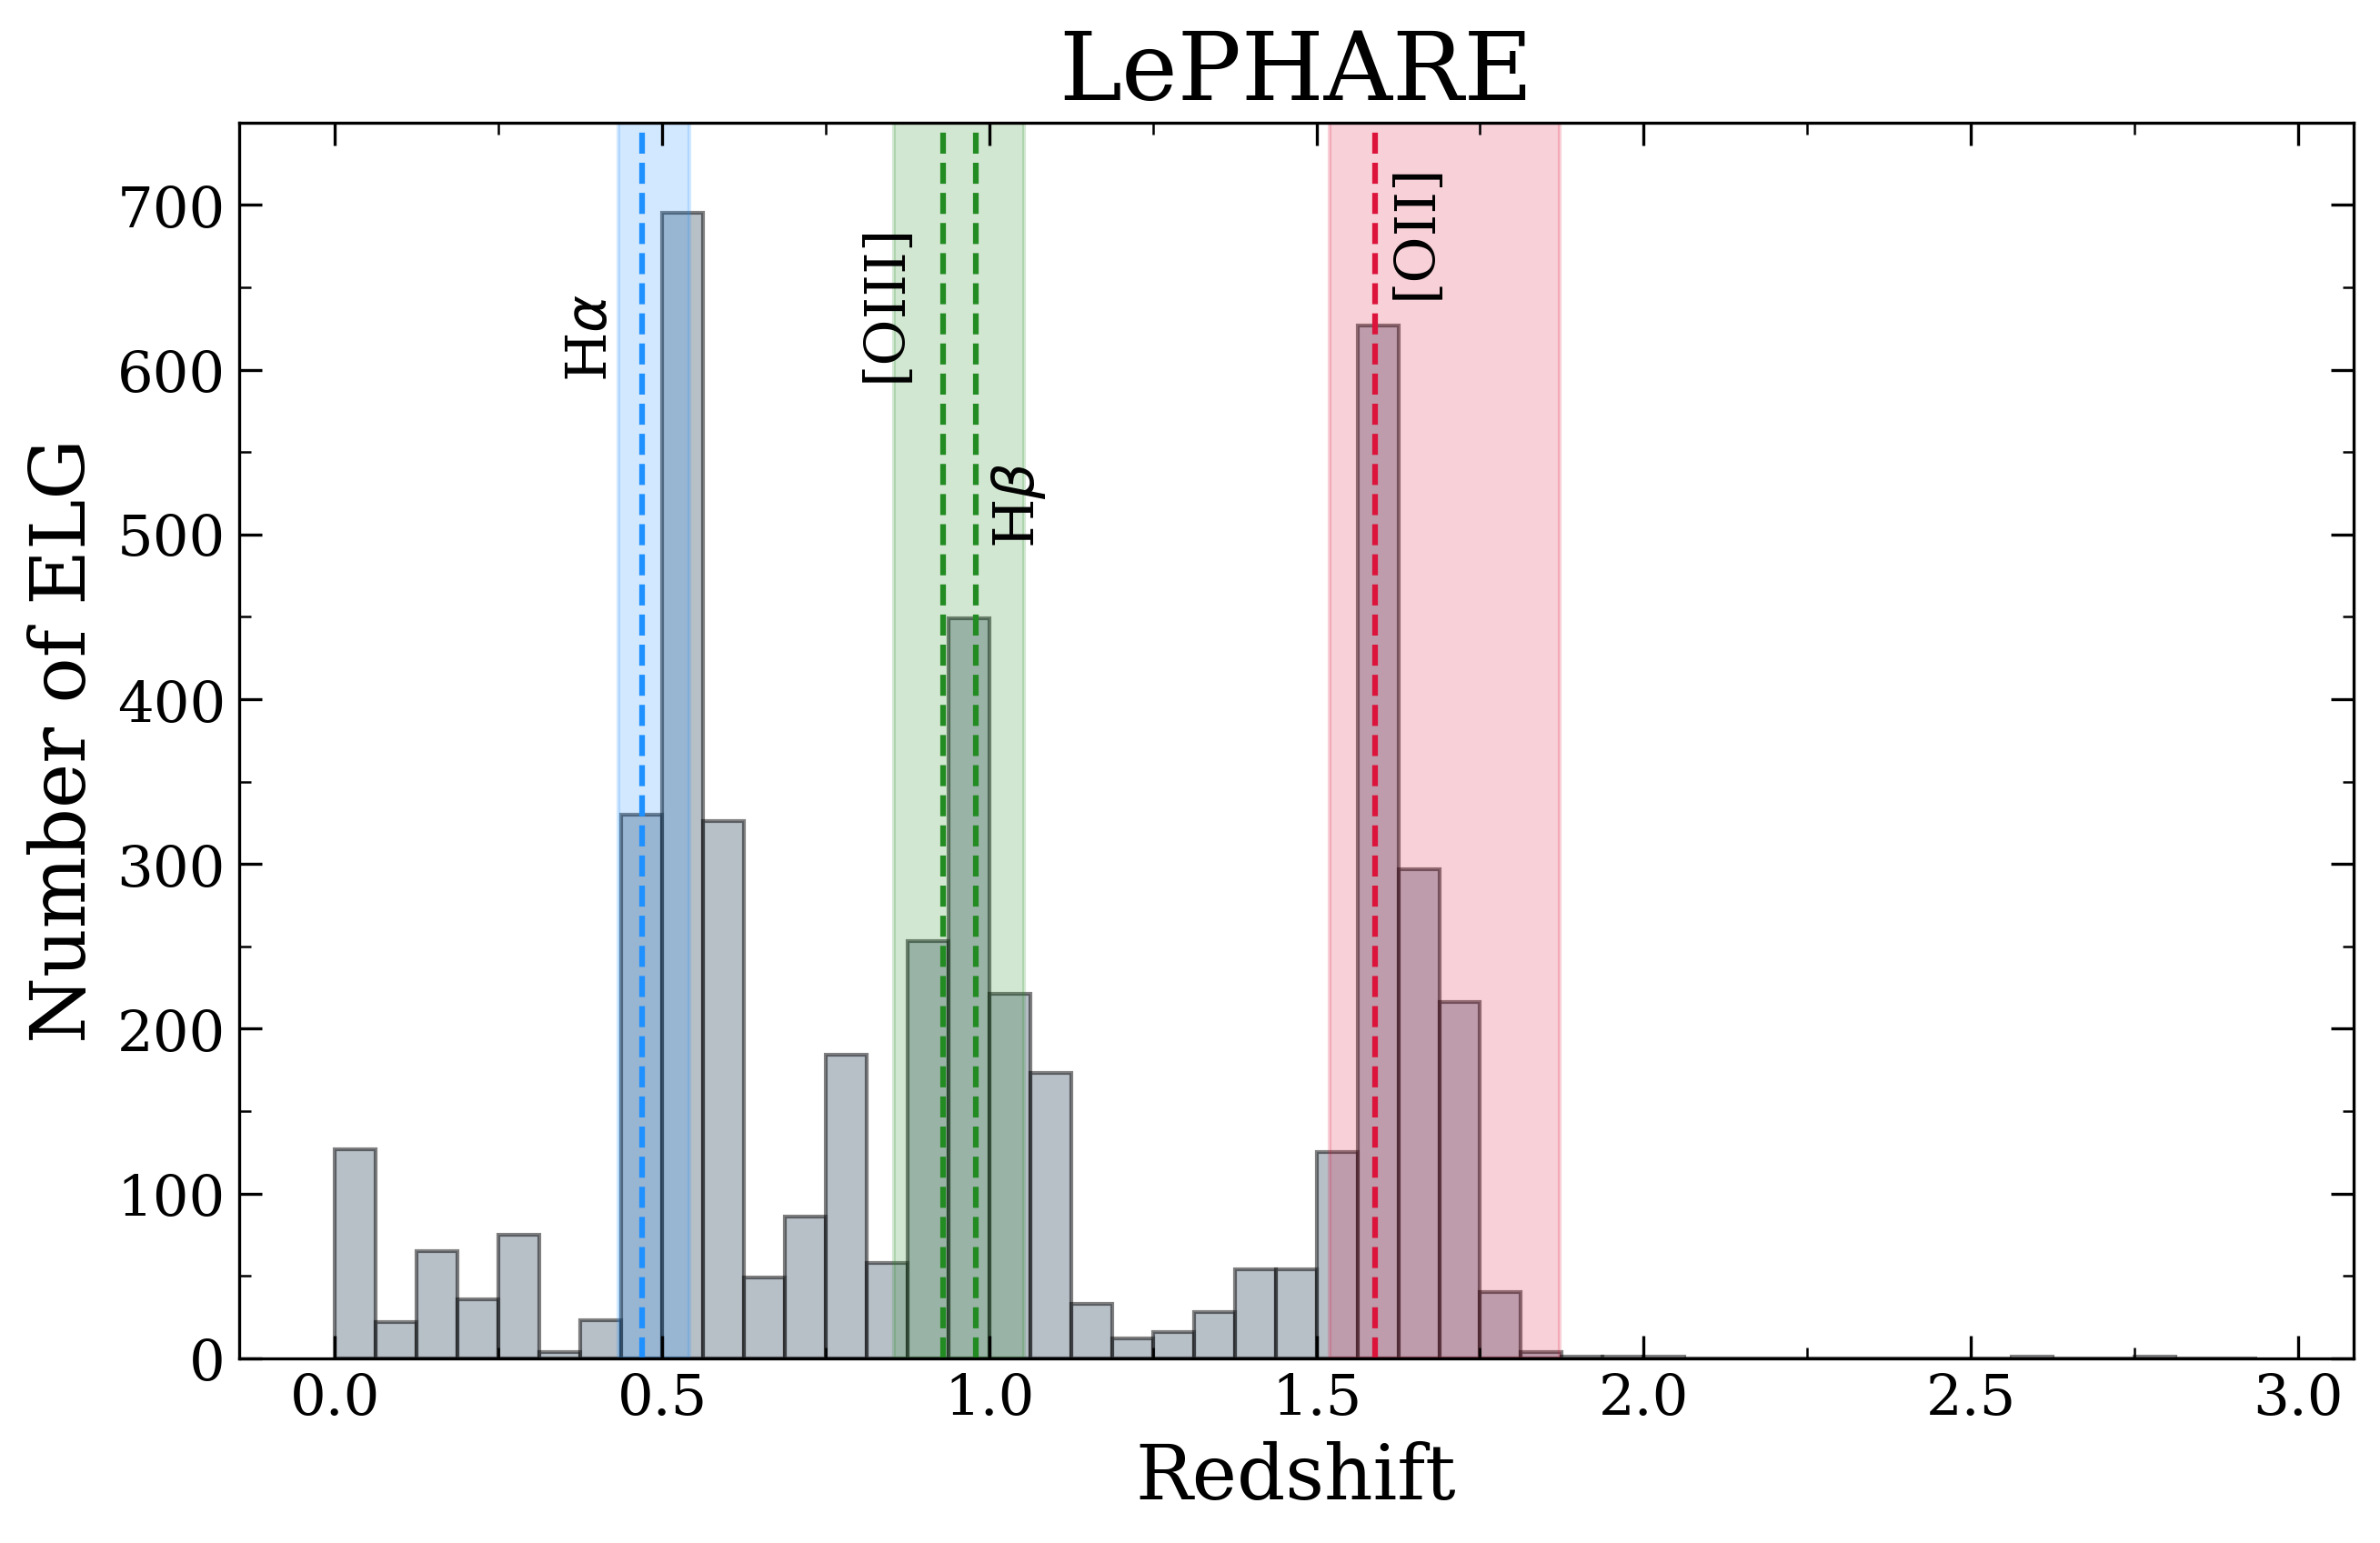

In [17]:
fig,ax=plt.subplots(figsize=(10,6), dpi=300)

bins = np.arange(0,3,0.0625)


ax.hist(table['Z_BEST'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.47-ah, 0.47+al, alpha=0.2, color='dodgerblue')
ax.text(0.35, 600, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.93-bh,0.93+bl, alpha=0.2, color='forestgreen')
ax.text(0.8, 600, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.59-ch, 1.59+cl, alpha=0.2, color='crimson')
ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', bottom=True, top=True, direction='in', length=3)
# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,750)
ax.set_title('LePHARE')
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

In [18]:
print(0.93-bh,0.93+bl)

0.8541287186741829 1.052722923755646


In [19]:
bins

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
       1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
       2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
       2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375])

In [20]:
len(table)

4690

# H$\alpha$

In [21]:
mask_H =  (0.47-ah < data_a['Z_BEST']) & (data_a['Z_BEST'] < 0.47+al)
H_a = data_a[mask_H]

In [22]:
print(len(H_a))

789


In [23]:
phi_star = 10**(-3.16) #* (u.Mpc ** -3)
L_star = (10**(41.72))
alpha = -1.75

In [24]:
print(L_star)

5.248074602497712e+41


In [25]:
aper = 2
H_flu = np.array([H_a['FLUX_APER_1'][i][aper] for i in range(len(H_a))])

In [26]:
H_mag = np.array([H_a['MAG_APER_1'][i][aper] for i in range(len(H_a))]) + 0.13
l_H = flux_lum(0.47, H_mag)

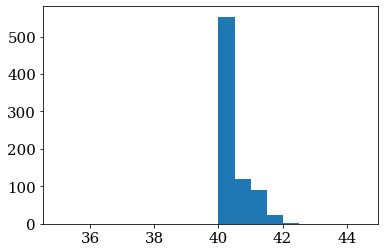

In [27]:
b = np.arange(35, 45,0.5)
alf_H, blf, clf =plt.hist(l_H[0], bins = b) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [28]:
bx_H = (b[0:-1]+b[1:])/2

binsize_H = bx_H[1]-bx_H[0]

lss_H = np.linspace(38,44,100)

In [29]:
len(bx_H)

19

In [30]:
vol_H = volume_redshift(0.47,2.94)

numb_ =  np.logspace((38),(44),100)
phia = sch(phi_star, numb_, L_star, alpha)

#Ly2007
phi_lyH = 10**(-2.40)
L_starLyH = 10**(41.29)
alphaLyH = -1.28
phi_LyH = sch(phi_lyH, numb_ ,L_starLyH, alphaLyH)

#Hayashi2016

phi_lyHa = 10**(-3.45)
L_starLyHa = 10**(41.86)
alphaLyHa = -1.75
phi_LyHa = sch(phi_lyHa, numb_,L_starLyHa, alphaLyHa)



In [31]:
vol_H

191049.7839893171

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


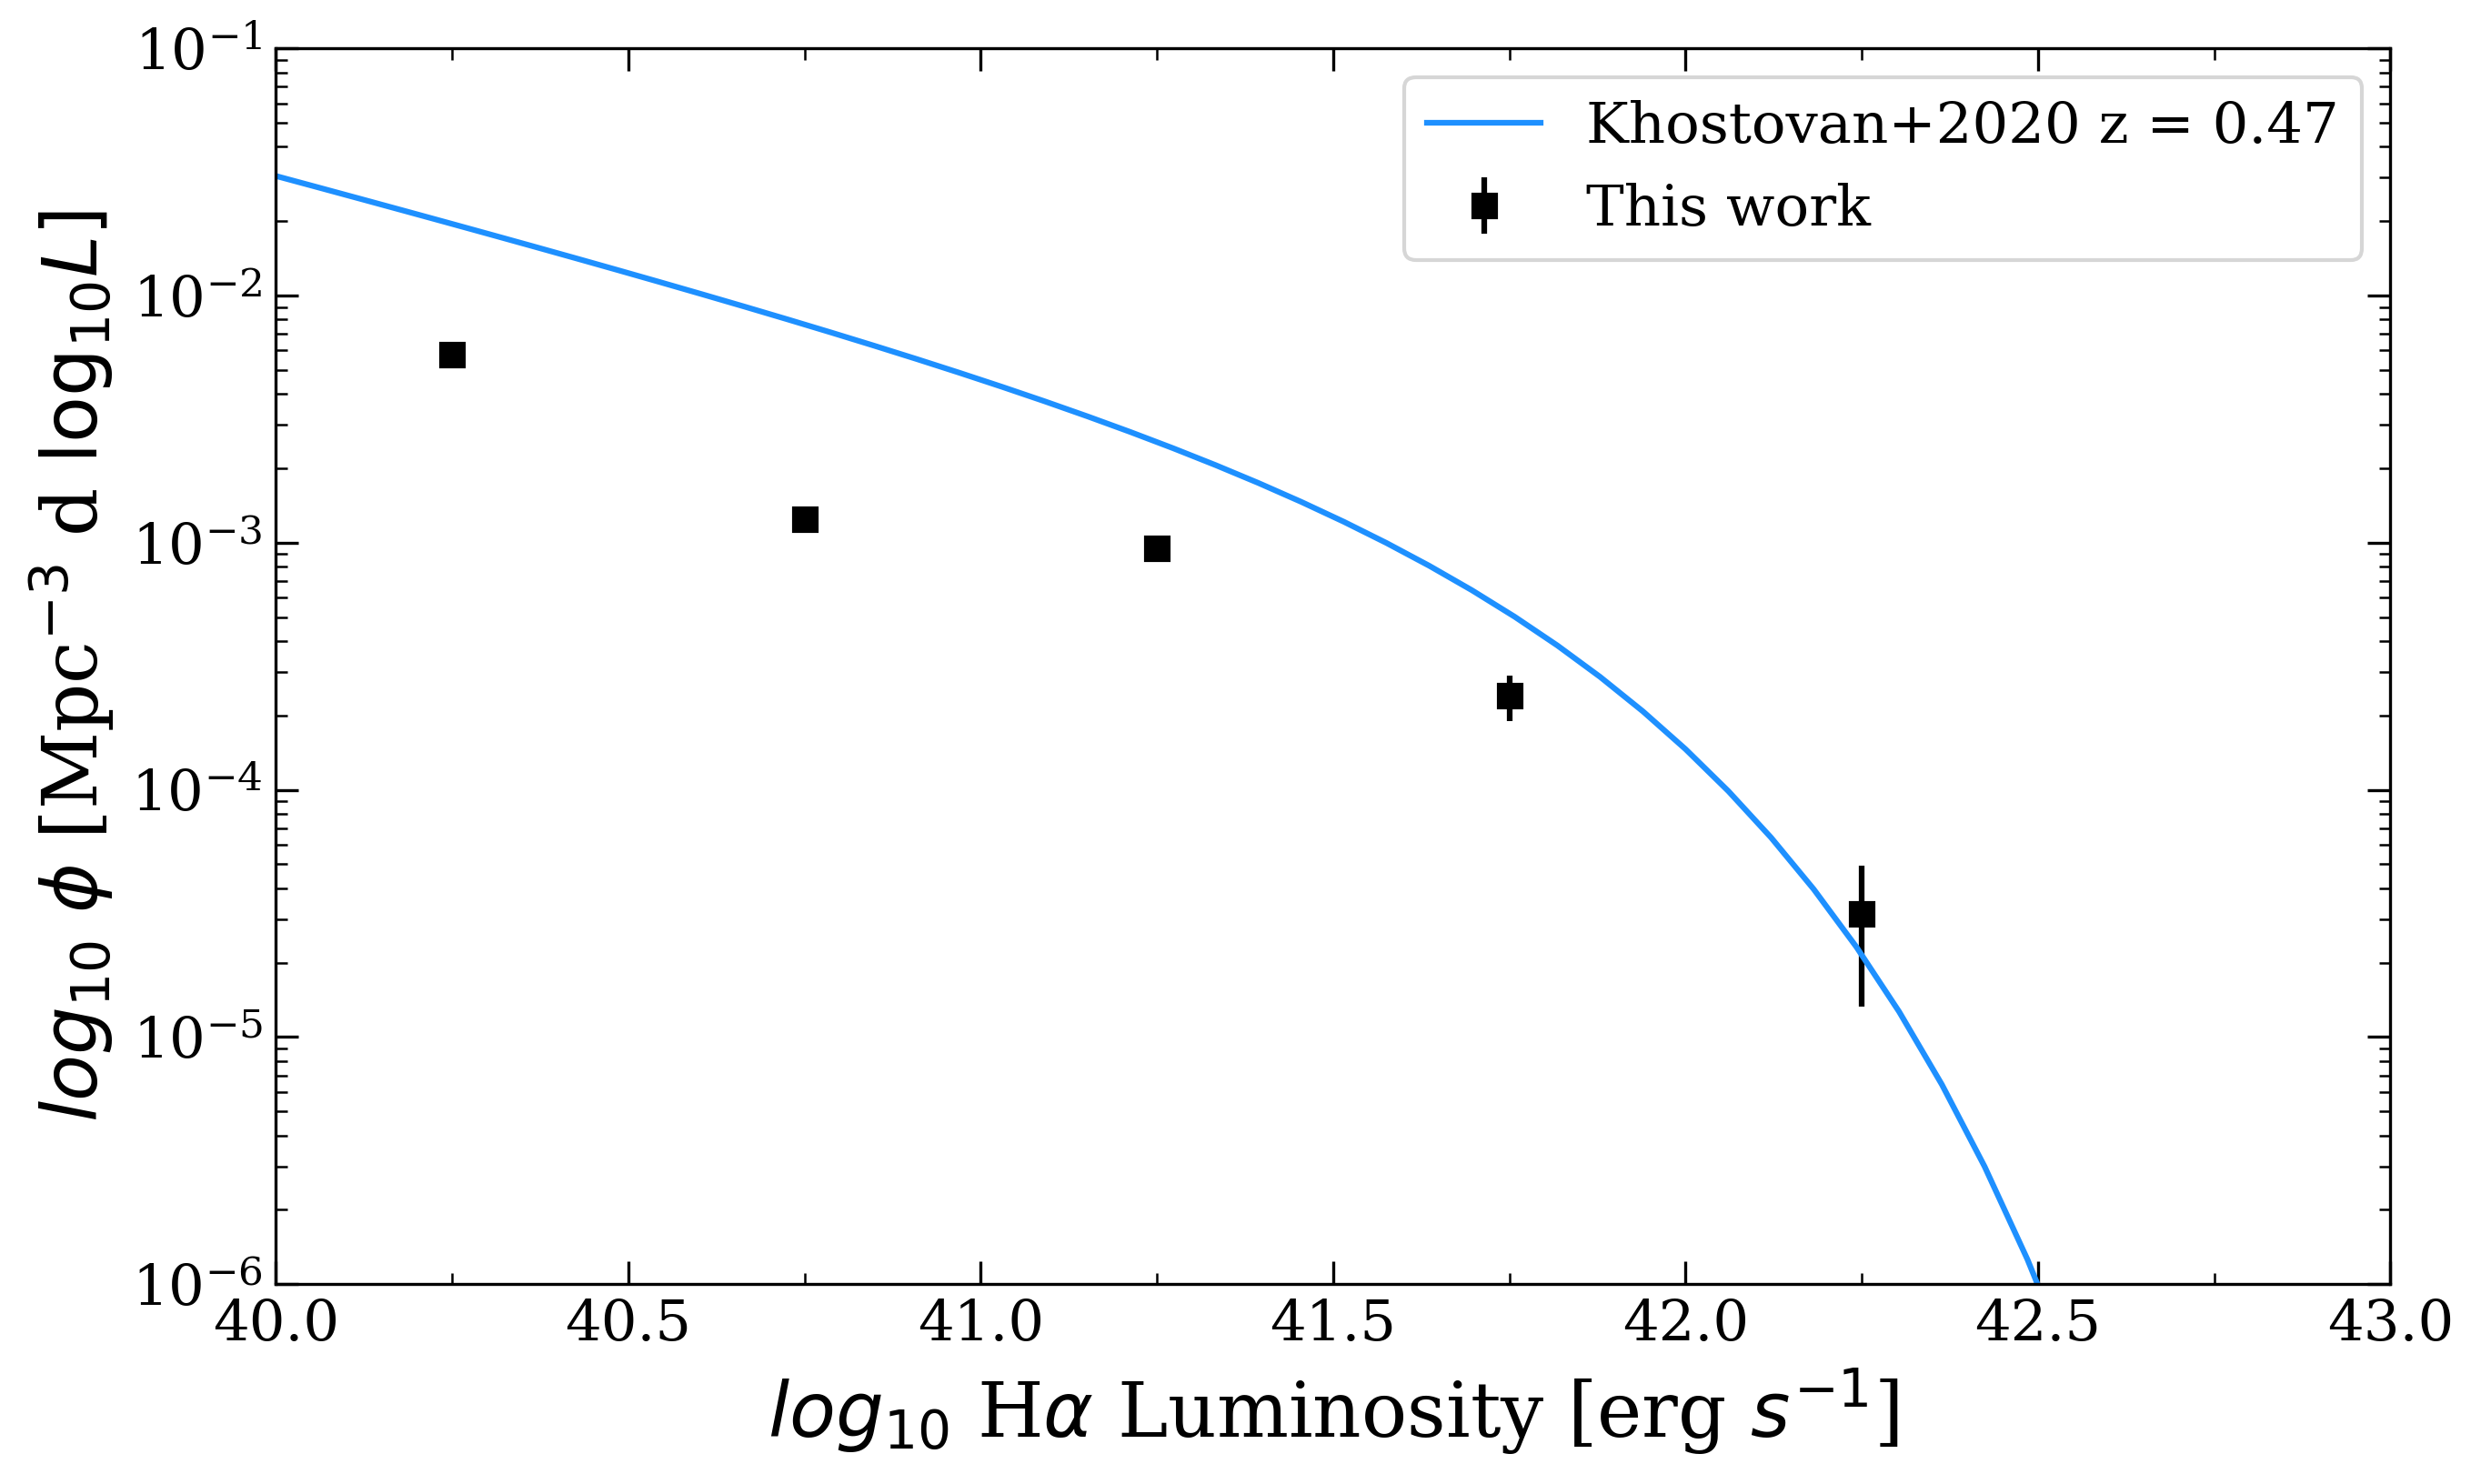

In [33]:
yy_H = alf_H/vol_H/binsize_H

#err_H = np.sqrt(1/(alf_H * np.log10(10)))
err_H = 1/np.sqrt(alf_H)
#err_H = 10

fig, ax = plt.subplots(figsize=(10,6), dpi = 300)
plt.errorbar(bx_H,yy_H, yerr = yy_H*err_H, ls = 'none', marker = 's', color = 'k', label = 'This work')
#plt.fill_between(lss_H, phi_min_H, phi_max_H, alpha = 0.1, color = 'blue')
ax.plot(lss_H, phia, color = 'dodgerblue', label = 'Khostovan+2020 z = 0.47')
# ax.plot(lss_H, phi_LyHa, color = 'deepskyblue', label = 'Hayashi+2016 z = 0.4', ls = ':')
# ax.plot(lss_H, phi_LyH, color = 'darkviolet', label = 'Ly+2007 z = 0.4', ls = '--')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40,43)

plt.xlabel(r'$log_{10}$ H$\alpha$ Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3}$ d $\log_{10} L]$')
plt.legend()
plt.show()

In [34]:
mask = yy_H > 0
yy_H2 = yy_H[mask]
bx_H2 = bx_H[mask]
err_H2 = err_H[mask]

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


Model: schechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             phis                   Ls                 alpha       
    --------------------- ---------------------- ------------------
    0.0001110042679133437 1.0472438097297453e+42 -1.714995763708219


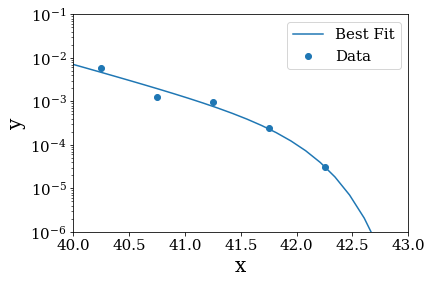

In [35]:
from astropy.modeling.models import custom_model
from astropy.modeling import models, fitting


@custom_model
def schechter(L, phis = phi_star, Ls = L_star, alpha = alpha):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)
    return np.log10(phi)


model = schechter()
fitter = fitting.LevMarLSQFitter()
best_fit_mH = fitter(model, 10**bx_H2, np.log10(yy_H2))
print(best_fit_mH)

x_new = np.linspace(30, 43, 100)
y_new = best_fit_mH(10**x_new)
#plt.plot(lss_H, phia, color = 'dodgerblue', label = 'Khostovan+2020 z = 0.47')
plt.scatter(bx_H2, yy_H2, label='Data')
plt.plot(x_new, 10**y_new, label='Best Fit')
plt.legend()
plt.yscale('log')
plt.xlim(40,43)
plt.ylim(1e-6,1e-1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Runt

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Runt

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarni

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Runt

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarnin

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarn

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: Runt

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarnin

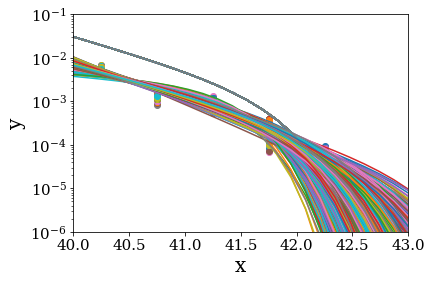

CPU times: user 1min 15s, sys: 3.24 s, total: 1min 18s
Wall time: 1min 14s


In [36]:
%%time
results = []
iterations = 2000
while len(results) < iterations:
    values_y = []
    for i, bins in enumerate(yy_H2): 
        s = np.random.normal(bins, bins*err_H2[i],1)
        values_y.append(s[0])
        
    
    values_y = np.array(values_y)

    model = schechter()
    fitter = fitting.LevMarLSQFitter()
    best_fit = fitter(model, 10**bx_H2, np.log10(values_y))
    results.append((best_fit.phis.value, best_fit.Ls.value, best_fit.alpha.value))
    
    x_new = np.linspace(30, 43, 100)
    y_new = best_fit(10**x_new)
    plt.scatter(bx_H2, values_y)
    plt.plot(x_new, 10**y_new)
    plt.yscale('log')
    plt.xlim(40,43)
    plt.ylim(1e-6,1e-1)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

results = np.array(results)

In [42]:
res_phi = np.array([results[i][0] for i in range(len(results))])
res_Ls = np.array([results[i][1] for i in range(len(results))])
res_alpha = np.array([results[i][2] for i in range(len(results))])
phi_scs =sigma_clipped_stats(res_phi)
Ls_scs = sigma_clipped_stats(res_Ls)
alpha_scs = sigma_clipped_stats(res_alpha)

phisH = np.log10(best_fit_mH.phis.value)
errphih =np.log10(phi_scs[1])-np.log10(phi_scs[1]-phi_scs[2])
errphil =np.log10(phi_scs[1])-np.log10(phi_scs[1]+phi_scs[2])

LsH =(np.log10(best_fit_mH.Ls.value))
errLsh =(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]-Ls_scs[2]))
errLsl =(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]+Ls_scs[2]))

alphaH =(best_fit_mH.alpha.value)
erralphah = ((alpha_scs[1])-(alpha_scs[1]-alpha_scs[2]))
erralphal =((alpha_scs[1])-(alpha_scs[1]+alpha_scs[2]))

Erros for Phi:
Erros for Ls:
Erros for alpha:


In [40]:
print('Erros for Phi:')
print(np.log10(best_fit_mH.phis.value))
print(np.log10(phi_scs[1])-np.log10(phi_scs[1]-phi_scs[2]))
print(np.log10(phi_scs[1])-np.log10(phi_scs[1]+phi_scs[2]))
print('Erros for Ls:')
print(np.log10(best_fit_mH.Ls.value))
print(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]-Ls_scs[2]))
print(np.log10(Ls_scs[1])-np.log10(Ls_scs[1]+Ls_scs[2]))
print('Erros for alpha:')
print(best_fit_mH.alpha.value)
print((alpha_scs[1])-(alpha_scs[1]-alpha_scs[2]))
print((alpha_scs[1])-(alpha_scs[1]+alpha_scs[2]))

Erros for Phi:
-3.954660323054951
0.4612775288033215
-0.2186094441140347
Erros for Ls:
42.020047801921145
0.3118753013694828
-0.1796469998304886
Erros for alpha:
-1.714995763708219
0.09683487275047598
-0.09683487275047598


In [47]:
phi_star_min = 10**(phisH - errphil) #* (u.Mpc ** -3)
L_star_min = (10**(LsH - errLsl))
phi_min_H = sch(phi_star_min, numb_, L_star_min,alphaH-erralphal)


phi_star_max = 10**(phisH - errphih) #* (u.Mpc ** -3)
L_star_max = (10**(LsH - errLsh))
phi_max_H = sch(phi_star_max, numb_, L_star_max, alphaH-erralphah)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


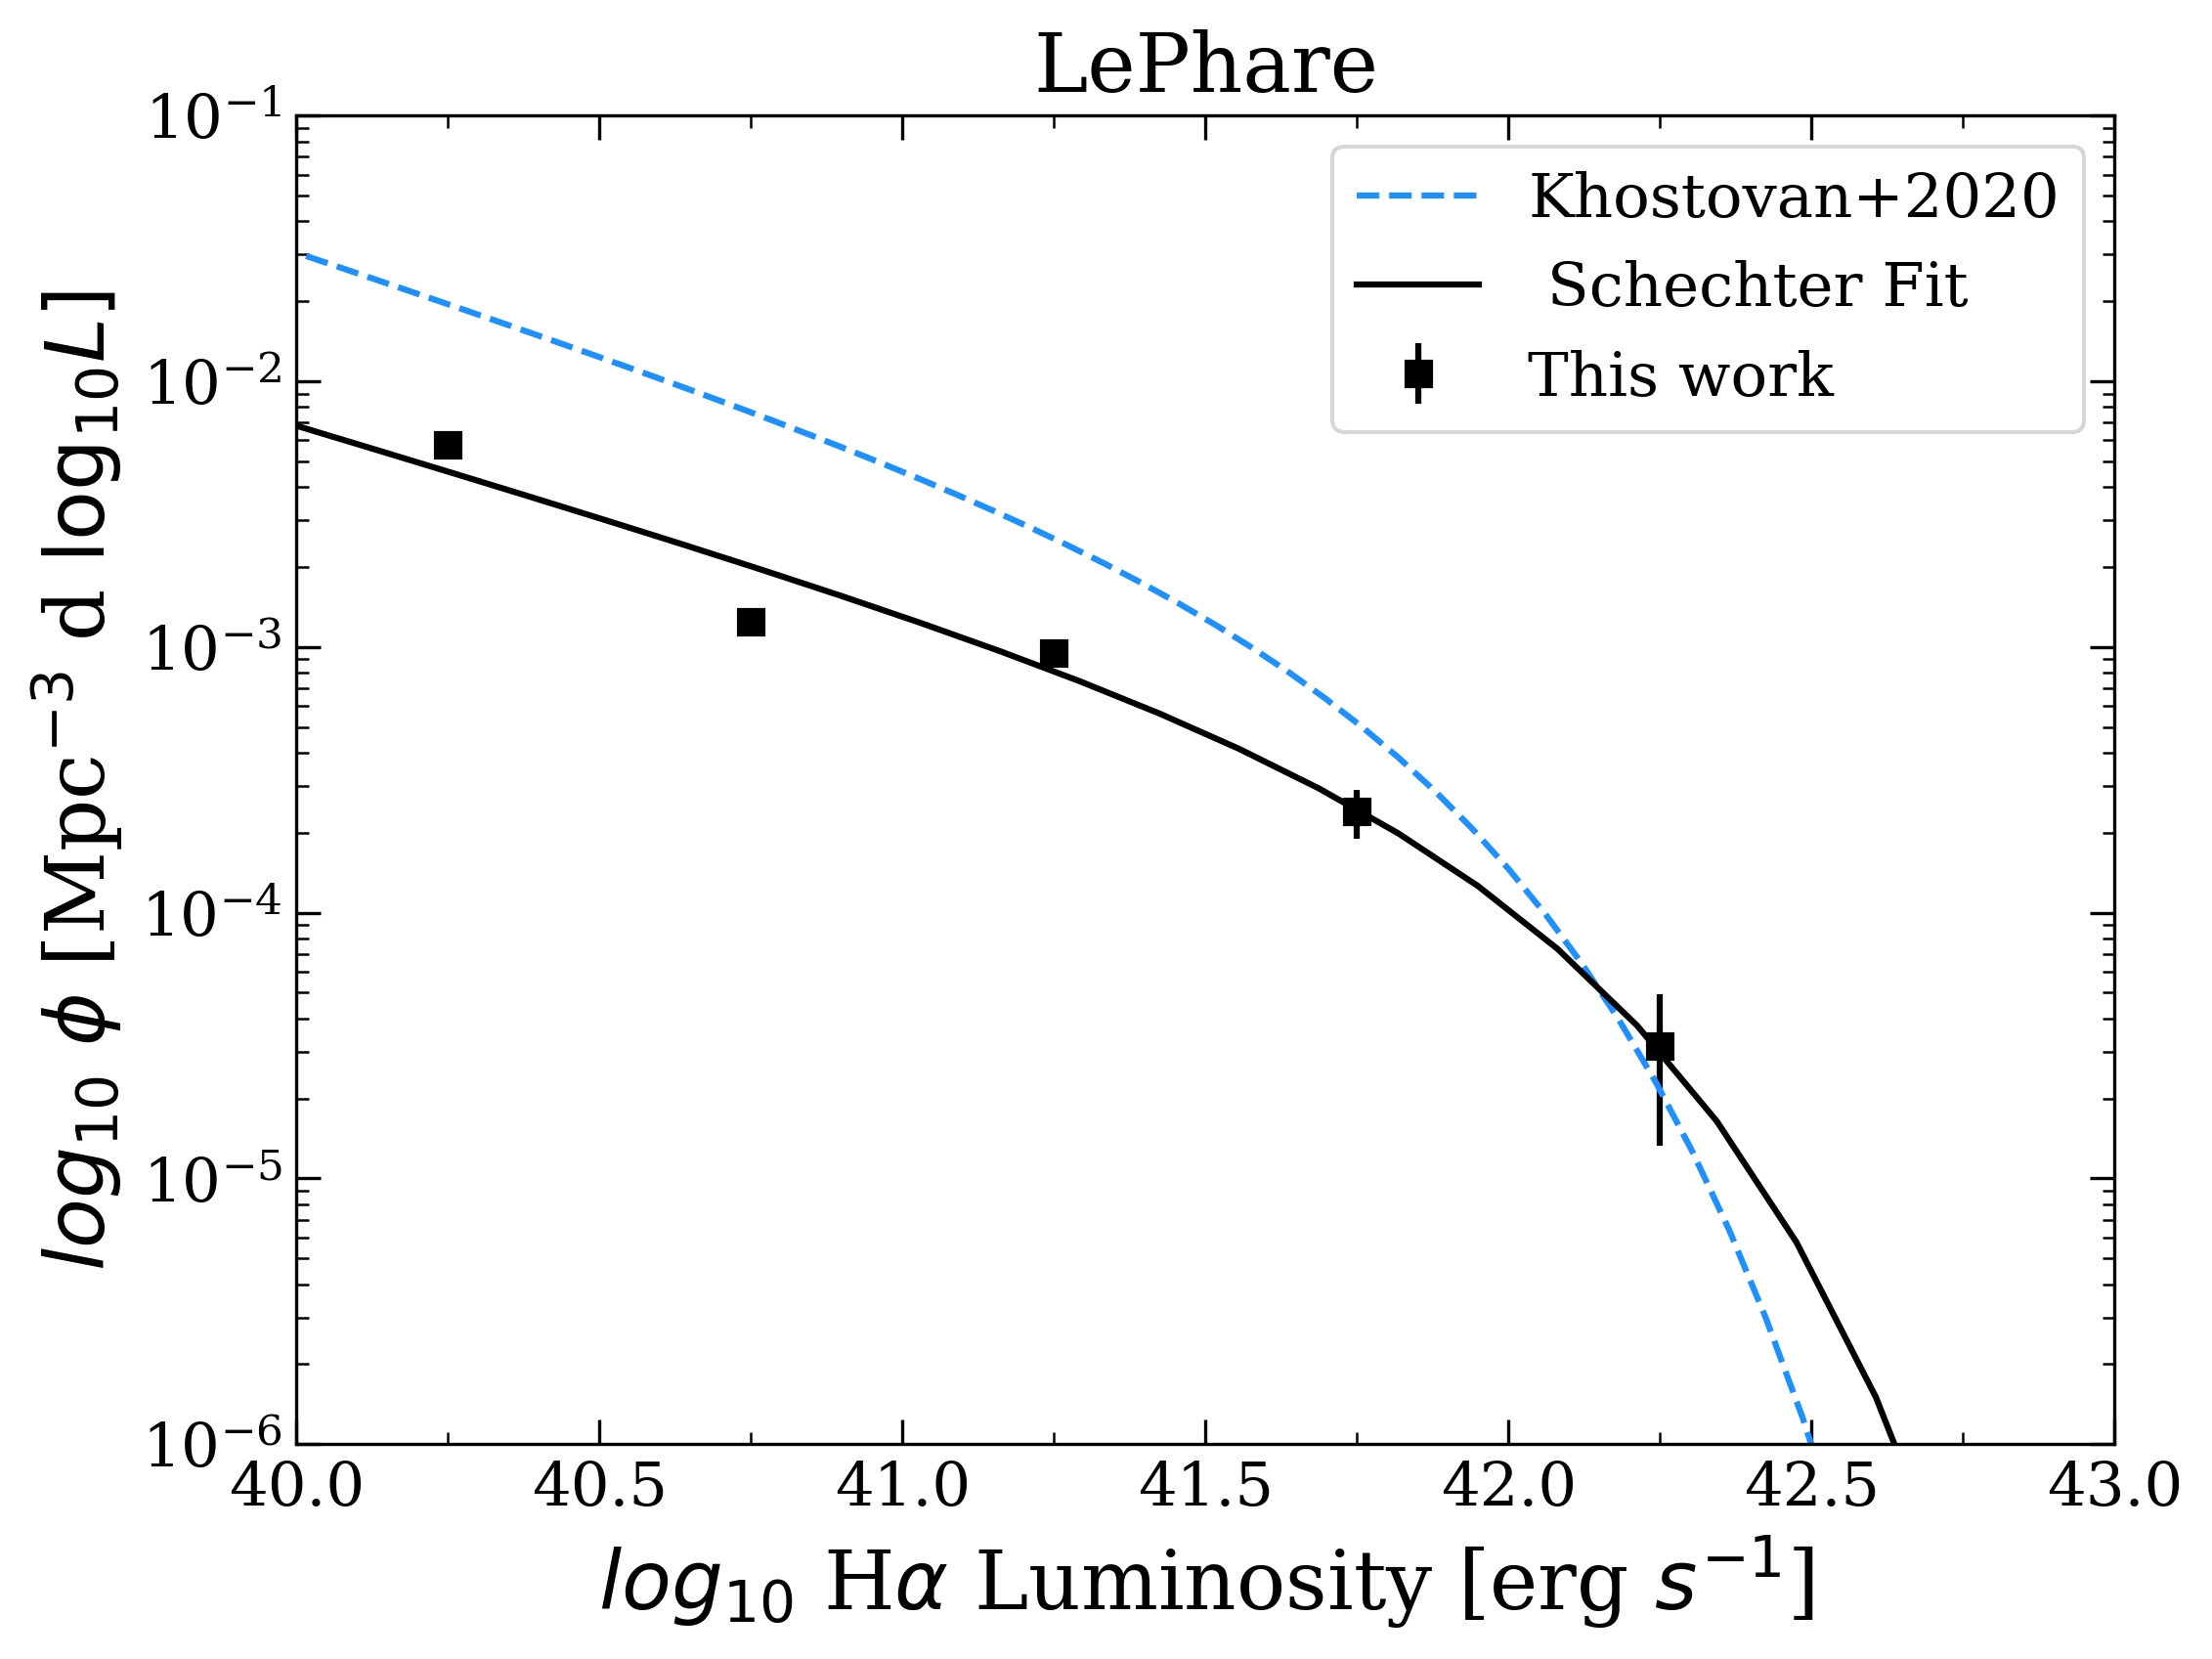

In [49]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 300)
plt.errorbar(bx_H,yy_H, yerr = yy_H*err_H, ls = 'none', marker = 's', color = 'k', label = 'This work')
#plt.fill_between(lss_H, phi_min_H, phi_max_H, alpha = 0.1, color = 'blue')
ax.plot(lss_H, phia, color = 'dodgerblue',  ls = '--',label = 'Khostovan+2020')
ax.plot(x_new, 10**y_new, label=' Schechter Fit', color = 'k')
# ax.plot(lss_H, phi_LyHa, color = 'deepskyblue', label = 'Hayashi+2016 z = 0.4', ls = ':')
# ax.plot(lss_H, phi_LyH, color = 'darkviolet', label = 'Ly+2007 z = 0.4', ls = '--')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje x
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.1 unidades en el eje x
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))      # Ticks principales cada 1 unidades en el eje y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))    # Ticks secundarios cada 0.5 unidades en el eje y
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', length=6)   # Ticks en el eje x en la parte inferior y superior
ax.tick_params(axis='x', which='minor', bottom=True, top=True, direction='in', length=3)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', length=6)   # Ticks en el eje y en el lado izquierdo y derecho
ax.tick_params(axis='y', which='minor', left=True, right=True, direction='in', length=3)

plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40,43)

plt.title('LePhare', size = 20)
plt.xlabel(r'$log_{10}$ H$\alpha$ Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3}$ d $\log_{10} L]$')
plt.legend()
plt.show()

# [OIII]

In [50]:
mask_2 = (0.93-bh< data_b['Z_BEST'] ) & (data_b['Z_BEST'] < 0.93+bl)
#mask2 = (0.7 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.1)
O_III = data_b[mask_2]

In [51]:
print(len(O_III))

915


In [52]:
phi_star2 = 10**(-2.16) #* (u.Mpc ** -3)
L_star2 = 10**(41.38)
alpha2 = -1.60

In [53]:
OIII_mag = np.array([O_III['MAG_APER_1'][i][aper] for i in range(len(O_III))])+0.13

l_OIII = flux_lum(0.93, OIII_mag)

In [54]:
1/len(O_III)*np.sqrt(len(O_III))

0.033058980245364314

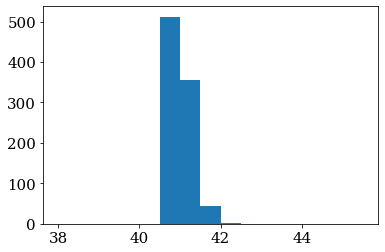

In [55]:
b2 = np.arange(38, 46,0.5)
alf_OIII, blf, clf =plt.hist(l_OIII[0], bins =b2) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [56]:
bx_OIII = (b2[0:-1]+b2[1:])/2

binsize_OIII = bx_OIII[1]-bx_OIII[0]

lss_OIII = np.linspace(38,44,100)

In [57]:
vol_OIII = volume_redshift(0.93,2.94)

numb_ =  np.logspace((38),(44),100)
phib = sch(phi_star2, numb_, L_star2, alpha2)


phi_star_min2 = 10**(-2.16 -0.12) #* (u.Mpc ** -3)
L_star_min2 = (10**(41.38-0.06))
phi_min_OIII = sch(phi_star_min2, numb_, L_star_min2, alpha2)


phi_star_max2 = 10**(-2.16 +0.1) #* (u.Mpc ** -3)
L_star_max2 = (10**(41.38 +0.07))
phi_max_OIII = sch(phi_star_max2, numb_, L_star_max2, alpha2)

In [58]:
vol_OIII

444482.2013246161

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


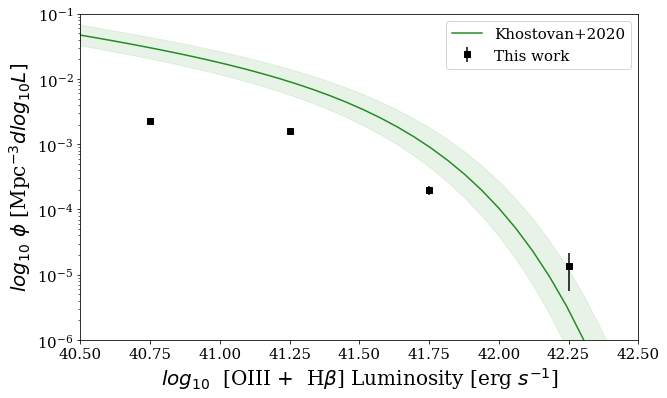

In [59]:
yy_OIII = alf_OIII/vol_OIII/binsize_OIII
err_OIII = 1/np.sqrt(alf_OIII)

ax,fig = plt.subplots(figsize = (10,6))
plt.errorbar(bx_OIII,yy_OIII, yerr = yy_OIII*err_OIII, ls = 'none', marker = 's', color = 'k' , label = 'This work' )
plt.fill_between(lss_OIII, phi_min_OIII, phi_max_OIII, alpha = 0.1, color = 'forestgreen')
plt.plot(lss_OIII, phib, color = 'forestgreen', label = 'Khostovan+2020')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40.5,42.5)

plt.xlabel(r'$log_{10}$  [OIII +  H$\beta$] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend()
plt.show()

In [60]:
mask2 = yy_OIII > 0
yy_OIII2 = yy_OIII[mask2]
bx_OIII2 = bx_OIII[mask2]
err_OIII2 = err_OIII[mask2]

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


Model: schechter2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             phis                    Ls         
    ---------------------- ---------------------
    0.00034589614866277957 5.234838627023529e+41


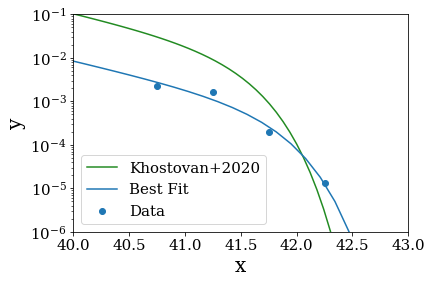

In [61]:
from astropy.modeling.models import custom_model


@custom_model
def schechter2(L, phis = phi_star2, Ls = L_star2):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha2)*np.exp(-L/Ls)
    return np.log10(phi)


model2 = schechter2()
fitter2 = fitting.LevMarLSQFitter()
best_fit2 = fitter2(model2, 10**bx_OIII2, np.log10(yy_OIII2))
print(best_fit2)

x_new = np.linspace(30, 43, 100)
y_new2 = best_fit2(10**x_new)
plt.plot(lss_OIII, phib, color = 'forestgreen', label = 'Khostovan+2020')
plt.scatter(bx_OIII2, yy_OIII2, label='Data')
plt.plot(x_new, 10**y_new2, label='Best Fit')
plt.legend()
plt.yscale('log')
plt.xlim(40,43)
plt.ylim(1e-6,1e-1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/py

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/py

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/s

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/py

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/py

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/py

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/py

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/pvfort/anacond

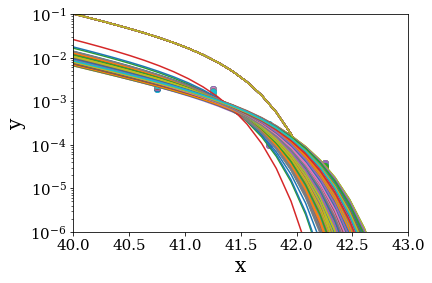

CPU times: user 58.7 s, sys: 3.22 s, total: 1min 1s
Wall time: 57.2 s


In [62]:
%%time
results2 = []
iterations = 2000
while len(results2) < iterations:
    values_y = []
    for i, bins in enumerate(yy_OIII2): 
        s = np.random.normal(bins, bins*err_OIII2[i],1)
        values_y.append(s[0])
        
    
    values_y = np.array(values_y)

    model2 = schechter2()
    fitter2 = fitting.LevMarLSQFitter()
    best_fit2 = fitter2(model2, 10**bx_OIII2, np.log10(values_y))
    results2.append((best_fit2.phis.value, best_fit2.Ls.value,best_fit.alpha.value))
    
    x_new = np.linspace(30, 43, 100)
    y_new2 = best_fit2(10**x_new)
    plt.scatter(bx_OIII2, values_y)
    plt.plot(x_new, 10**y_new2)
    plt.yscale('log')
    plt.xlim(40,43)
    plt.ylim(1e-6,1e-1)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

results2 = np.array(results2).

In [63]:
res_phi2 = np.array([results2[i][0] for i in range(len(results2))])
res_Ls2 = np.array([results2[i][1] for i in range(len(results2))])
phi2_scs =sigma_clipped_stats(res_phi2)
Ls2_scs = sigma_clipped_stats(res_Ls2)

print('Erros for Phi:')
print(np.log10(phi2_scs[1])-np.log10(phi2_scs[1]-phi2_scs[2]))
print(np.log10(phi2_scs[1])-np.log10(phi2_scs[1]+phi2_scs[2]))
print('Erros for Ls:')
print(np.log10(Ls2_scs[1])-np.log10(Ls2_scs[1]-Ls2_scs[2]))
print(np.log10(Ls2_scs[1])-np.log10(Ls2_scs[1]+Ls2_scs[2]))


Erros for Phi:
0.08512119289893771
-0.07114041311861463
Erros for Ls:
0.09829604600345476
-0.08010281664681429


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


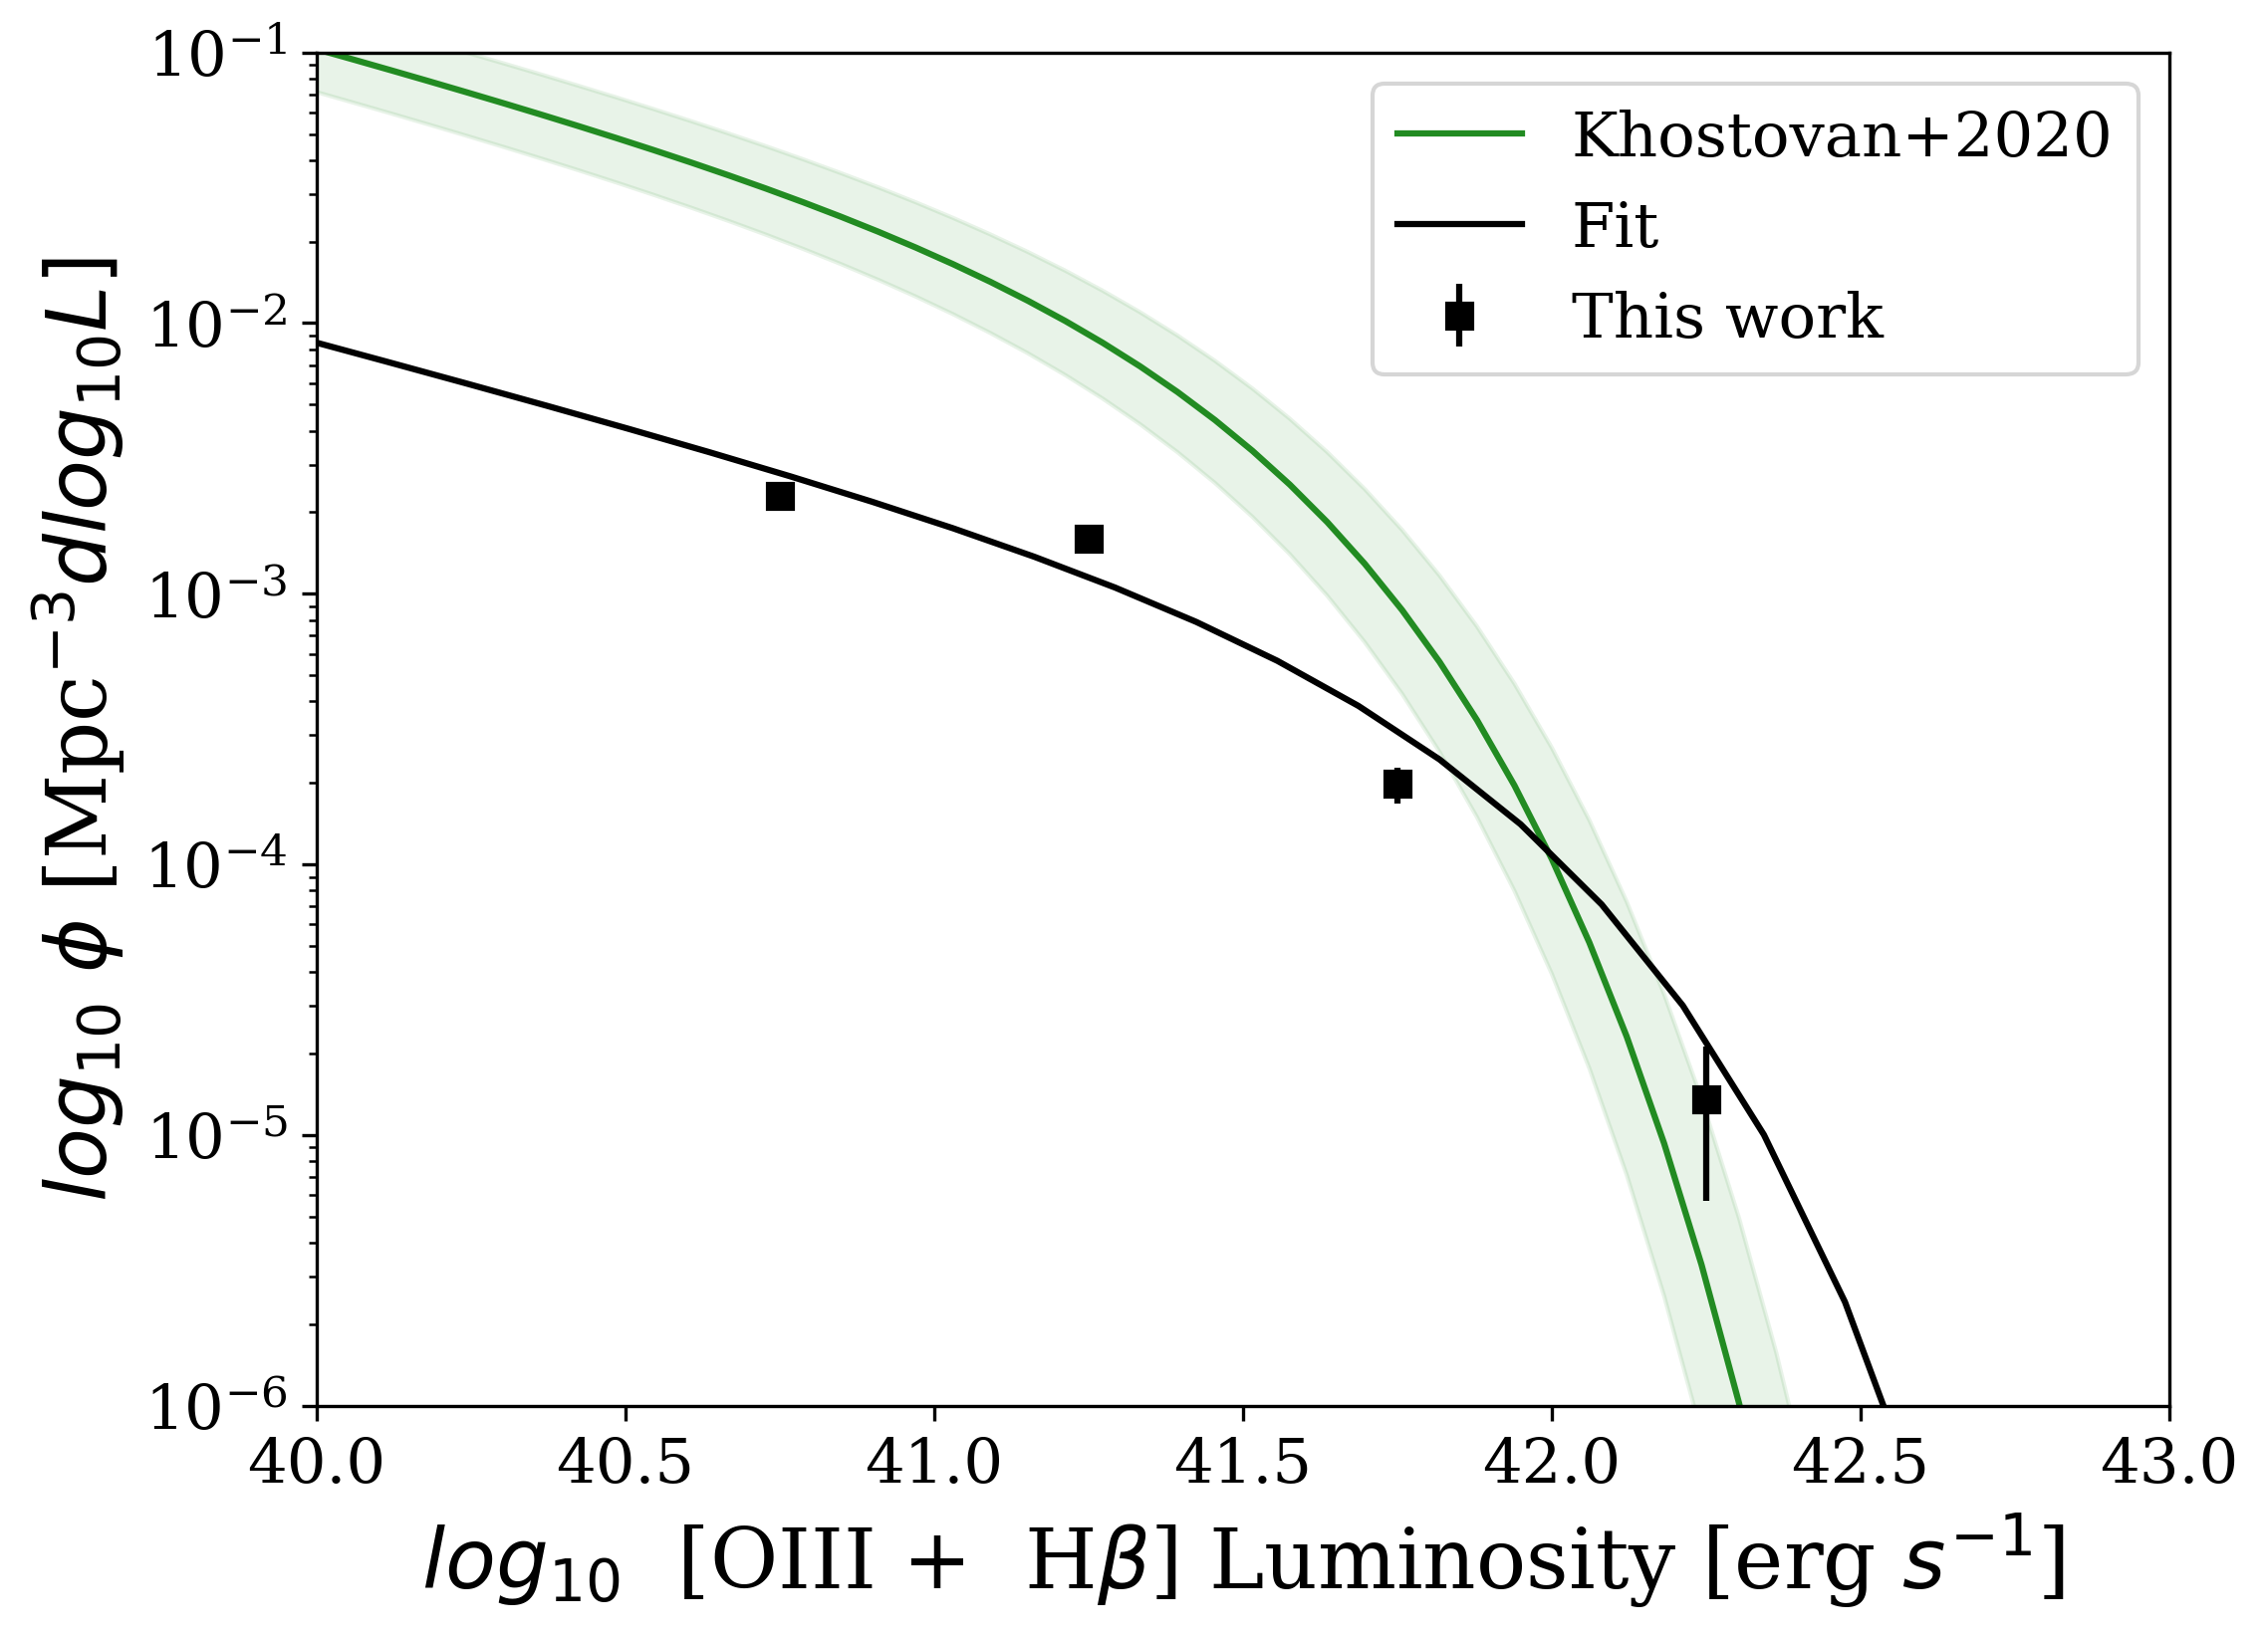

In [64]:
ax,fig = plt.subplots(figsize = (8,6), dpi = 300)
plt.errorbar(bx_OIII,yy_OIII, yerr = yy_OIII*err_OIII, ls = 'none', marker = 's', color = 'k' , label = 'This work' )
plt.fill_between(lss_OIII, phi_min_OIII, phi_max_OIII, alpha = 0.1, color = 'forestgreen')
plt.plot(lss_OIII, phib, color = 'forestgreen', label = 'Khostovan+2020')
plt.plot(x_new, 10**y_new2, label='Fit', color = 'k')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(40,43)

plt.xlabel(r'$log_{10}$  [OIII +  H$\beta$] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend()
plt.show()

# [OII]

In [65]:
mask_3 = (1.59-ch < data_c['Z_BEST'] ) & (data_c['Z_BEST'] < 1.59+cl)
#mask3 = (1.25 < table['Z_BEST'] ) & (table['Z_BEST'] < 2)
O_II = data_c[mask_3]

In [66]:
print(len(O_II))

1280


In [67]:
phi_star3 = 10**(-1.97) 
L_star3 =10**(41.66)
alpha3 = -1.30

In [68]:
OII_mag = np.array([O_II['MAG_APER_1'][i][aper] for i in range(len(O_II))]) +0.13
l_OII = flux_lum(1.59, OII_mag)

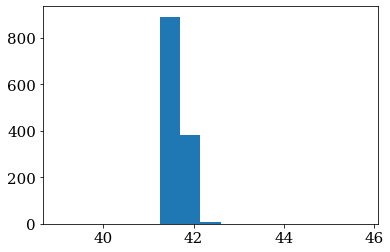

In [69]:
b3 = np.arange(39, 46,0.45)
alf_OII, blf, clf =plt.hist(l_OII[0], bins =b3) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [70]:
bx_OII = (b3[0:-1]+b3[1:])/2

binsize_OII = bx_OII[1]-bx_OII[0]

lss_OII = np.linspace(38,44,100)

In [71]:
vol_OII = volume_redshift(1.59,2.94)

numb_ =  np.logspace((38),(44),100)
phic = sch(phi_star3, numb_, L_star3, alpha3)


phi_star_min3 = 10**(-1.97 -0.07) #* (u.Mpc ** -3)
L_star_min3 = (10**(41.66 -0.03))
phi_min_OII = sch(phi_star_min3, numb_, L_star_min3, alpha3)


phi_star_max3 = 10**(-1.97 +0.07) #* (u.Mpc ** -3)
L_star_max3 = (10**(41.66 +0.03))
phi_max_OII = sch(phi_star_max3, numb_, L_star_max3, alpha3)

In [72]:
vol_OII

645906.0287183358

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


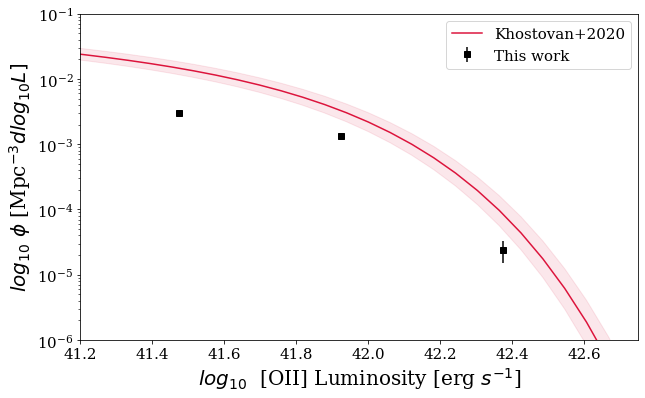

In [73]:
yy_OII = alf_OII/vol_OII/binsize_OII
err_OII = 1/np.sqrt(alf_OII)

ax,fig = plt.subplots(figsize = (10,6))
plt.errorbar(bx_OII,yy_OII, yerr = yy_OII*err_OII, ls = 'none', marker = 's', color = 'k', label = 'This work' )
plt.fill_between(lss_OII, phi_min_OII, phi_max_OII, alpha = 0.1, color = 'crimson')
plt.plot(lss_OII, phic, color = 'crimson', label = 'Khostovan+2020')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(41.2,42.75)

plt.xlabel(r'$log_{10}$  [OII] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend()
plt.show()

In [74]:
mask3 = yy_OII > 0
yy_OII2 = yy_OII[mask3]
bx_OII2 = bx_OII[mask3]
err_OII2 = err_OII[mask3]

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Model: schechter3
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            phis                   Ls         
    -------------------- ---------------------
    0.002837458744238388 4.718521982119859e+41


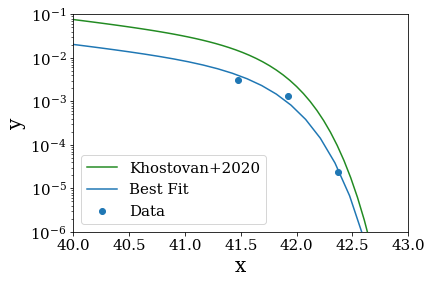

In [75]:
@custom_model
def schechter3(L, phis = phi_star3, Ls = L_star3):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha3)*np.exp(-L/Ls)
    return np.log10(phi)


model3 = schechter3()
fitter3 = fitting.LevMarLSQFitter()
best_fit3 = fitter3(model3, 10**bx_OII2, np.log10(yy_OII2))
print(best_fit3)

x_new = np.linspace(30, 43, 100)
y_new3 = best_fit3(10**x_new)
plt.plot(lss_OII, phic, color = 'forestgreen', label = 'Khostovan+2020')
plt.scatter(bx_OII2, yy_OII2, label='Data')
plt.plot(x_new, 10**y_new3, label='Best Fit')
plt.legend()
plt.yscale('log')
plt.xlim(40,43)
plt.ylim(1e-6,1e-1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [76]:
phi_star_3 = (0.0028647501612388336) #* (u.Mpc ** -3)
L_star_3 = 4.693801047189284e+41
phi_OII = sch(phi_star_3, x_new, L_star_3, alpha3)

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


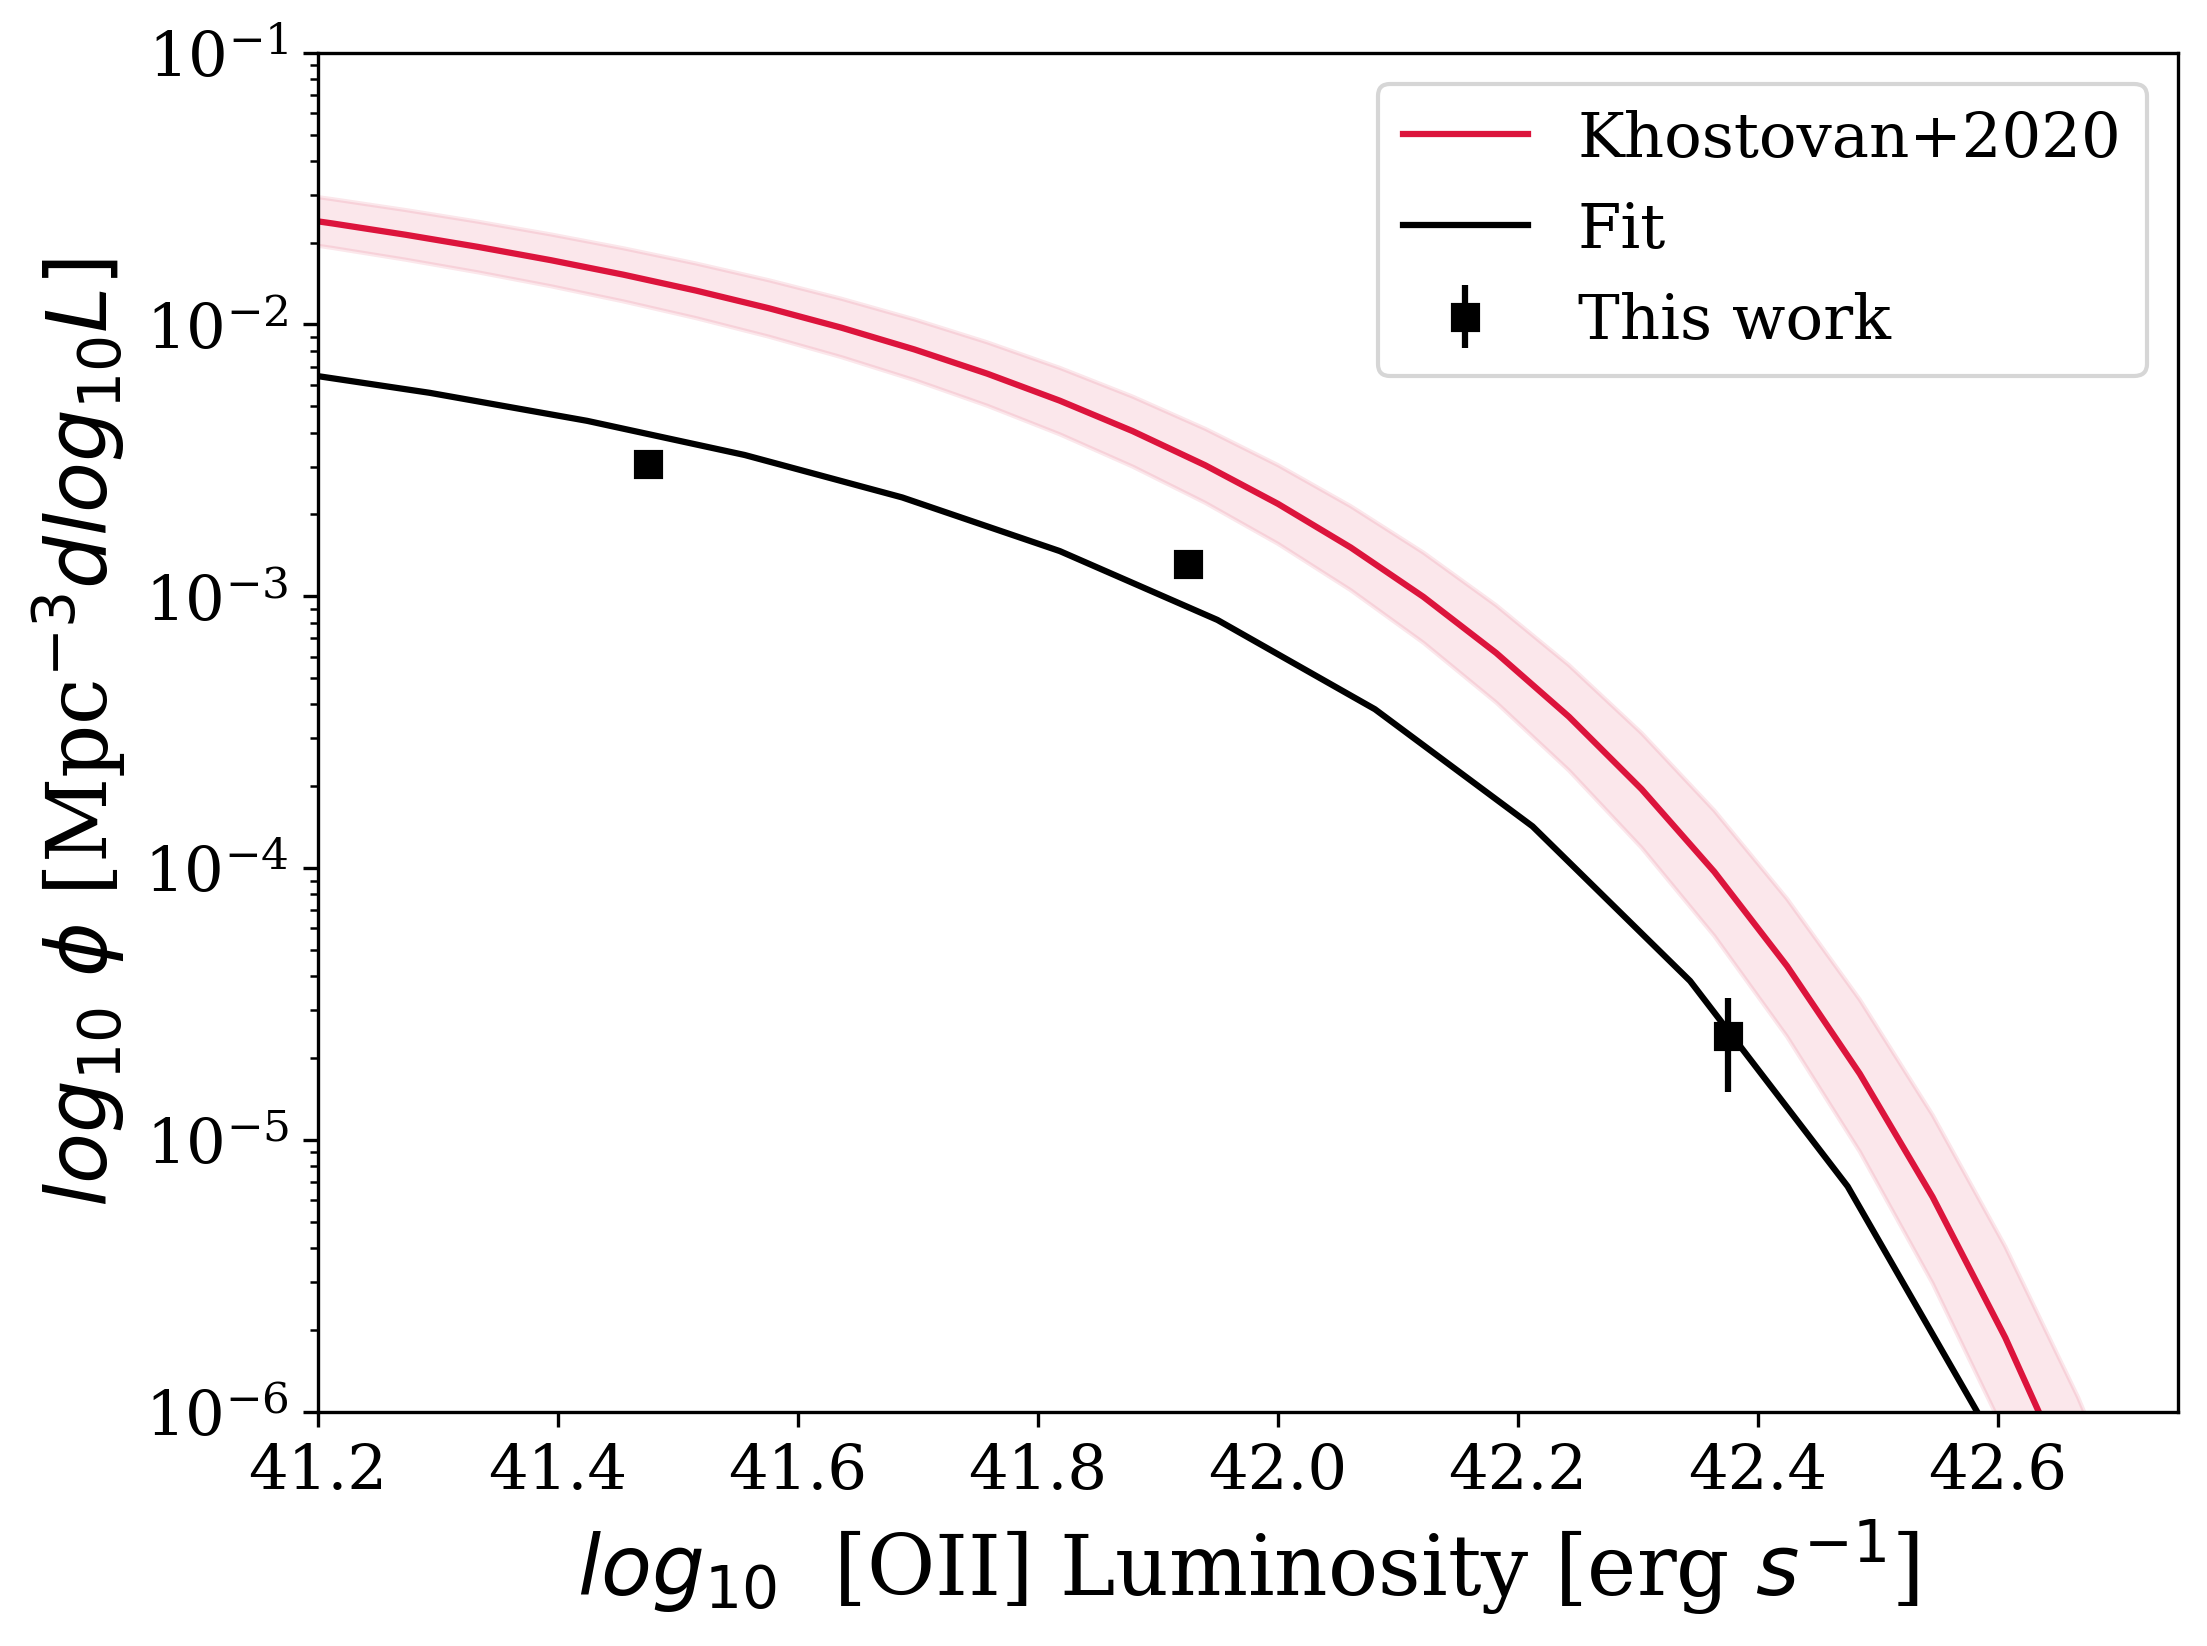

In [77]:
ax,fig = plt.subplots(figsize = (8,6), dpi = 300)
plt.errorbar(bx_OII,yy_OII, yerr = yy_OII*err_OII, ls = 'none', marker = 's', color = 'k', label = 'This work' )
plt.fill_between(lss_OII, phi_min_OII, phi_max_OII, alpha = 0.1, color = 'crimson')
plt.plot(lss_OII, phic, color = 'crimson', label = 'Khostovan+2020')
plt.plot(x_new, 10**y_new3, label='Fit', color = 'k')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(41.2,42.75)

plt.xlabel(r'$log_{10}$  [OII] Luminosity [erg $s^{-1}$]')
plt.ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.legend()
plt.show()

In [78]:
print(err_OII2*yy_OII2)

[1.02639175e-04 6.73313830e-05 9.10263583e-06]


/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/pvfort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path

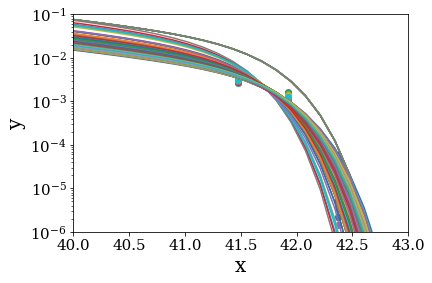

CPU times: user 1min 6s, sys: 3.4 s, total: 1min 10s
Wall time: 1min 4s


In [79]:
%%time
results3 = []
iterations = 2000
while len(results3) < iterations:
    values_y = []
    for i, bins in enumerate(yy_OII2): 
        s = np.random.normal(bins, bins*err_OII2[i],1)
        values_y.append(s[0])
        
    
    values_y = np.array(values_y)

    model3 = schechter3()
    fitter3 = fitting.LevMarLSQFitter()
    best_fit3 = fitter3(model3, 10**bx_OII2, np.log10(values_y))
    results3.append((best_fit3.phis.value, best_fit3.Ls.value))
    
    x_new = np.linspace(30, 43, 100)
    y_new3 = best_fit3(10**x_new)
    plt.scatter(bx_OII2, values_y)
    plt.plot(x_new, 10**y_new3)
    plt.yscale('log')
    plt.xlim(40,43)
    plt.ylim(1e-6,1e-1)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

results3 = np.array(results3)

In [80]:
res_phi3 = np.array([results3[i][0] for i in range(len(results3))])
res_Ls3 = np.array([results3[i][1] for i in range(len(results3))])
phi3_scs =sigma_clipped_stats(res_phi3)
Ls3_scs = sigma_clipped_stats(res_Ls3)
print('Erros for Phi:')
print(np.log10(phi3_scs[1])-np.log10(phi3_scs[1]-phi3_scs[2]))
print(np.log10(phi3_scs[1])-np.log10(phi3_scs[1]+phi3_scs[2]))
print('Erros for Ls:')
print(np.log10(Ls3_scs[1])-np.log10(Ls3_scs[1]-Ls3_scs[2]))
print(np.log10(Ls3_scs[1])-np.log10(Ls3_scs[1]+Ls3_scs[2]))

Erros for Phi:
0.05779438896763445
-0.05099880406230639
Erros for Ls:
0.04100439768740216
-0.03746472259886957
